ECGR 6119: Applied AI - Assignment 3 <br>
Name: Michael Campo <br>
Model: Faster RCNN w/ MobileNet v3 320 backbone <br>
Objective: Train model to detect fruit. An apple and orange is used for the real time example.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets, models
from torch import nn, optim
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import copy
from PIL import Image
from google.colab import files

In [2]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="e1GyZpWVSWHPJAsUpcKN")
project = rf.workspace("linmuyang").project("fruit_detection-arpfm")
dataset = project.version(1).download("coco")

In [5]:
!git clone https://github.com/pytorch/vision.git
!cd vision
#!git checkout v0.13.1

Cloning into 'vision'...
remote: Enumerating objects: 232804, done.
remote: Counting objects: 100% (6475/6475), done.
remote: Compressing objects: 100% (601/601), done.
remote: Total 232804 (delta 6005), reused 6275 (delta 5863), pack-reused 226329
Receiving objects: 100% (232804/232804), 468.89 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (211075/211075), done.


In [6]:
%%shell

cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [8]:
data_path = "/content/fruit_detection-1"
print(os.path.join(data_path, "train", "_annotations.coco.json"))

/content/fruit_detection-1/train/_annotations.coco.json


In [9]:
coco = COCO(os.path.join(data_path, "train", "_annotations.coco.json"))
categories = coco.cats
num_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'fruit', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'apple', 'supercategory': 'fruit'},
 2: {'id': 2, 'name': 'banana', 'supercategory': 'fruit'},
 3: {'id': 3, 'name': 'orange', 'supercategory': 'fruit'},
 4: {'id': 4, 'name': 'pear', 'supercategory': 'fruit'}}

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['fruit', 'apple', 'banana', 'orange', 'pear']

In [15]:
def get_transforms(train=False):
    if train:
      transform = A.Compose([
          A.Resize(640, 640),      # resize input to 640px
          A.HorizontalFlip(p=0.4),
          A.VerticalFlip(p=0.4),
          A.RandomBrightnessContrast(p=0.2),
          A.Rotate(p=0.2),
          A.Blur(p=0.3),
          ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
      transform = A.Compose([
          A.Resize(640,640),
          ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [16]:
class HouseholdDetection (datasets.VisionDataset):
  def __init__(self, root, split='train', transforms=None, transform=None, target_transform=None):
    super().__init__(root, transforms)
    self.split = split
    self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))     # get path of coco annotations
    self.ids = list(sorted(self.coco.imgs.keys()))                            # get ditctionary keys
    self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]    # get array of labels in image

  def _load_image(self, id: int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv2.imread(os.path.join(self.root, self.split, path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                            # convert image to RBG
    return image

  def _load_target(self, id):
    return self.coco.loadAnns(self.coco.getAnnIds(id))                        # get annotations for image

  def __getitem__(self, index):
    id = self.ids[index]
    image = self._load_image(id)
    target = self._load_target(id)
    target = copy.deepcopy(self._load_target(id))

    boxes = [t['bbox'] + [t['category_id']] for t in target]
             
    if self.transforms is not None:
      transformed = self.transforms(image=image, bboxes=boxes)

    image = transformed['image']
    boxes = transformed['bboxes']

    new_boxes = []
    for box in boxes:
      xmin = box[0]
      xmax = xmin + box[2]
      ymin = box[1]
      ymax = ymin + box[3]
      new_boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.tensor(new_boxes, dtype=torch.float32)

    t_target = {}
    t_target['boxes'] = boxes
    t_target['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
    t_target['image_id'] = torch.tensor([t['image_id'] for t in target])
    t_target['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
    if len(boxes) == 0:
      t_target['area'] = 0
    else:
       t_target['area'] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    
    return image.div(255), t_target

  def __len__(self):
    return len(self.ids)



In [17]:
ann = coco.getAnnIds(0)
coco.loadAnns(ann)

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [31, 14, 344, 376],
  'area': 129344,
  'segmentation': [],
  'iscrowd': 0}]

In [18]:
train_ds = HouseholdDetection(root=data_path, transforms=get_transforms(True))
test_ds = HouseholdDetection(root=data_path, transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


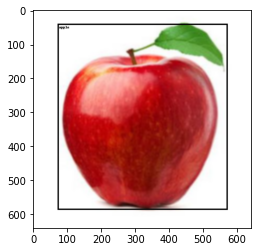

In [22]:
# view a sample
img1 = train_ds[7]
img_int = torch.tensor(img1[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, img1[1]['boxes'], [classes[i] for i in img1[1]['labels']], width=4
).permute(1, 2, 0))

In [23]:
len(train_ds)

297

In [24]:
# Obtain the faster RCNN model
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

rcnn_model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
input_features = rcnn_model.roi_heads.box_predictor.cls_score.in_features
rcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
rcnn_model = rcnn_model.to(device)
device

device(type='cuda')

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [28]:
# get parameters and set optimizer
params = [p for p in rcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.8, nesterov=True, weight_decay=1e-4)
num_epochs = 15

In [29]:
# train model

for epoch in range(num_epochs):
  train_one_epoch(rcnn_model, optimizer, train_loader, device, epoch, print_freq=100)

Epoch: [0]  [  0/149]  eta: 0:17:08  lr: 0.000077  loss: 2.2984 (2.2984)  loss_classifier: 1.5020 (1.5020)  loss_box_reg: 0.7431 (0.7431)  loss_objectness: 0.0465 (0.0465)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 6.9031  data: 0.1614  max mem: 325
Epoch: [0]  [100/149]  eta: 0:00:06  lr: 0.006828  loss: 1.5592 (1.9286)  loss_classifier: 0.6921 (0.8308)  loss_box_reg: 0.8326 (1.0525)  loss_objectness: 0.0235 (0.0351)  loss_rpn_box_reg: 0.0097 (0.0102)  time: 0.0726  data: 0.0093  max mem: 420
Epoch: [0]  [148/149]  eta: 0:00:00  lr: 0.010000  loss: 1.3603 (1.7794)  loss_classifier: 0.4871 (0.7590)  loss_box_reg: 0.7725 (0.9758)  loss_objectness: 0.0268 (0.0348)  loss_rpn_box_reg: 0.0070 (0.0098)  time: 0.0716  data: 0.0088  max mem: 420
Epoch: [0] Total time: 0:00:17 (0.1194 s / it)
Epoch: [1]  [  0/149]  eta: 0:00:41  lr: 0.010000  loss: 1.2751 (1.2751)  loss_classifier: 0.3451 (0.3451)  loss_box_reg: 0.8972 (0.8972)  loss_objectness: 0.0273 (0.0273)  loss_rpn_box_reg: 0.0055 (0.0055)

In [30]:
from torch.nn.modules import loss
rcnn_model.eval()
torch.cuda.empty_cache()

In [40]:
img2, _ = train_ds[22]
img_int2 = torch.tensor(img2*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = rcnn_model([img2.to(device)])
    pred = prediction[0]

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


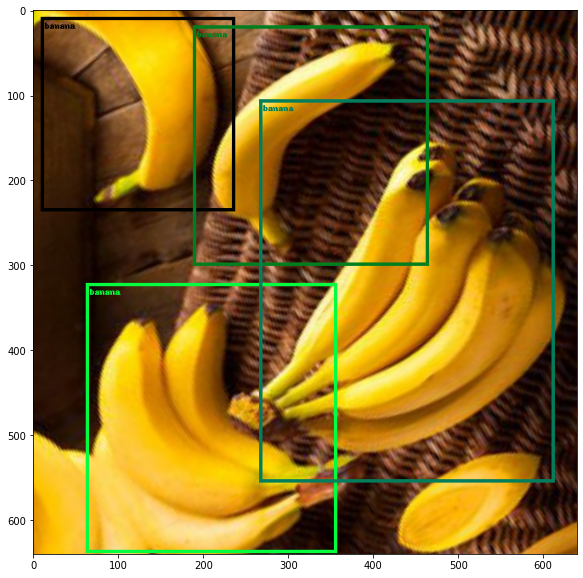

In [41]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int2,
    pred['boxes'][pred['scores'] > 0.7],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.7].tolist()], width=4
).permute(1, 2, 0))

In [48]:
torch.save(rcnn_model.state_dict(), '/content/rcnn5/rcnn5_weights.pt')
torch.save(rcnn_model, '/content/rcnn5/rcnn5_model.pt')

In [50]:
!zip -r rcnn5.zip rcnn5

  adding: rcnn5/ (stored 0%)
  adding: rcnn5/rcnn5_model.pt (deflated 7%)
  adding: rcnn5/rcnn5_weights.pt (deflated 7%)


In [51]:
files.download("rcnn5.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import rcnn helper library to do inference 
!git clone https://github.com/sovit-123/fasterrcnn-pytorch-training-pipeline.git
!pip install -r requirements.txt

In [ ]:
# run inference using webcam as video source
!python inference_video.py -i 0 -d 0 -th 0.65 -si -m "C:\Users\micha\AI_ML\fasterrcnn-pytorch-training-pipeline\rcnn_weights\rcnn5_model.pt"